# Investigating Global COVID-19 Vaccinations

I'm curious to see how vaccination rates compare between countries and within countries (specifically the United States, India, and Israel).

Israel is the country with the fastest vaccination rate, already surpassing 30% of the total population vaccinated. I'm curious to see how this compares to the other local Arab states (I know the UAE is in second in terms of vaccination rate), and how vaccination rates among Palestinians compare, if that data is available.

The United States is of course a personal interest to investigate, as I live here, but it also underwent a presidential election and transfer of power during the pandemic, so it'll be interesting to see how vaccination rates compare before and after inauguration and how they compare across the country. Throughout the pandemic I've been following [Dan Goodspeed's COVID-19 charts](https://dangoodspeed.com/covid/total-cases-since-june), I especially like the chart which compares COVID-19 rates per capita between states and colors them by partisanship (red or blue). Thinking a similar idea here, but instead comparing vaccination rates.

India is another personal interest to investigate, but similar to how the USA underwent a political upheaval (change in leadership, attempted insurrection, etc.) India is going through a period of major social/economic upheaval as well through the farmers protests. Here I am more interested in investigating how the protests have impacted the incidence of COVID-19 and vaccination rates. So this will just be a graph of cumulative vaccinations (or rates per week) with points labeled with major events in the protests.

## Datasets

For this investigation I'm using the Our World In Data COVID-19 dataset and their COVID-19 vaccination-specific dataset, which is large (17MB) and probably a bit in excess of what I need. I'm going to start by loading in the entire thing, but take a focused look at the `vaccinations` dataset. 

In [108]:
!curl -o covid19_data.csv https://covid.ourworldindata.org/data/owid-covid-data.csv
!curl -o covid19_vaccinationdata.csv https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv

# Let's fetch the WorldBank population dataset
!rm country_pop API_SP* Metadata*
!curl -o country_pop 'http://api.worldbank.org/V2/country/all/indicators/SP.POP.TOTL?downloadformat=csv'
!unzip country_pop
!ls
# trim first four metadata lines (seriously why are these lines even here?)
!tail -n +5 "API_SP.POP.TOTL_DS2_EN_csv_v2_2064197.csv" > "country_pop.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 17.1M    0 17.1M    0     0  55.3M      0 --:--:-- --:--:-- --:--:-- 55.5M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  232k  100  232k    0     0  2322k      0 --:--:-- --:--:-- --:--:-- 2322k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80069  100 80069    0     0   207k      0 --:--:-- --:--:-- --:--:--  207k
Archive:  country_pop
  inflating: Metadata_Indicator_API_SP.POP.TOTL_DS2_EN_csv_v2_2064197.csv  
  inflating: API_SP.POP.TOTL_DS2_EN_csv_v2_2064197.csv  
  inflating: Metadata_Country_API_SP.POP.TOTL_DS2_EN_csv_v2_2064197.csv  
API_SP.POP.TOTL_DS2_EN_csv_v2_2064197.csv
country_pop
countr

That cURL request just fetched two CSV files, one for the general dataset and one for the vaccination specific dataset. This cell should be rerun every day as that's how frequently Our World in Data updates their dataset. Now we can look into the set and see what we want. As a preliminary chart I'm going to make a line chart of weekly vaccination rates by country (top ten will be graphed with distinct colors) starting in December. So the y-axis will be number of people fully (two doses) vaccinated per 100 people, and the x-axis will be dates (week index, with 0 being first week of December).

## Exploring the Data

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, date
import math

import urllib
import os
import csv

In [126]:
df = pd.read_csv("covid19_vaccinationdata.csv")
pop_df = pd.read_csv("country_pop.csv")
# trim
vaccine_df = df[["location", "iso_code", "date",  "total_vaccinations", "daily_vaccinations", 
                 "daily_vaccinations_raw", "people_fully_vaccinated",  "daily_vaccinations_per_million",
                 "people_fully_vaccinated_per_hundred"]]

# I'm calculating the per capita rate for daily doses administered myself
# (daily_vaccinations_per_million in the Our World in Data dataset). This is because I'll be using the
# World Bank dataset later which draws it's population counts from a more complete set of sources
# and I want to be consistent about what population values I'm using. I will fill in the NaN calculated values with 
# per capita values from OWiD's dataset.
year = 2020
while year >= 1960:
  pop_df["2020"].fillna(inplace=True, value=pop_df[str(year)])
  year -= 1
pop_df = pop_df[["Country Name", "2020"]]

pop_df.rename(inplace=True, columns={"2020": "latest_available_population"})
pop_df.dropna(inplace=True, how="any", axis="index")
vaccine_df = pd.merge(vaccine_df, pop_df, left_on=["location"], right_on=["Country Name"], how="outer")
vaccine_df = vaccine_df.assign(daily_vaccinations_per_million_calculated = lambda x: 
                               x["daily_vaccinations"] / (x["latest_available_population"] / 1000000))
vaccine_df["daily_vaccinations_per_million_calculated"].fillna(inplace=True, value=vaccine_df["daily_vaccinations_per_million"])
vaccine_df.drop(inplace=True, columns=["daily_vaccinations_per_million"])
vaccine_df.rename(inplace=True, columns={
  "daily_vaccinations_per_million_calculated":"daily_vaccinations_per_million"
})

location                                      176
iso_code                                      460
date                                          176
total_vaccinations                           1549
daily_vaccinations                            324
daily_vaccinations_raw                       1951
people_fully_vaccinated                      2726
daily_vaccinations_per_million                324
people_fully_vaccinated_per_hundred          2726
Country Name                                  575
latest_available_population                   575
daily_vaccinations_per_million_calculated     882
dtype: int64


So we have metrics for daily vaccinations, and this is provided in a number of ways: 
- `daily_vaccinations_raw`: only calculated when there is data on total vaccinations for consecutive days.
- `daily_vaccinations`: calculated for every day
  1. Fill gaps in data for `total_vaccinations` assuming a perfectly linear progression
  2. Calculate the daily vaccinations as the difference in the interpolated totals day by day
  3. The smoothed daily vaccinations are calculated by taking an average of the previous 7 days as calculated in Step 2, or fewer if 7 data points are not available. 
  - Further description provided [here](https://github.com/owid/covid-19-data/issues/333#issuecomment-763015298).
- `daily_vaccinations_per_million`: calculated for every day as `daily_vaccinations` / (country population in millions)


As a starting point let's get the average daily vaccination rate by taking the `total_vaccinations` for each country and dividing by the number of days since the first day they reported vaccination numbers.


In [111]:
def get_daily_average(df, doses=True):
  # doses is a boolean flag to indicate whether to measure the average as a fraction of individual vaccine doses administered
  #   or of people fully vaccinated
  cumulative_val = "total_vaccinations" if doses else "people_fully_vaccinated"

  # Get total vaccinations for all countries and drop null vals by row
  tv_raw = df[["location", cumulative_val]].copy()
  tv_raw.dropna(inplace=True, axis="index", how="any")

  countries = tv_raw.location.unique()

  # Create a dictionary where keys are countries and values are average daily vaccinations
  dv_dict = {}
  for country in countries:
    tv_country = tv_raw[tv_raw["location"] == country]
    total_vac = tv_country[cumulative_val].iloc[-1]
    # Assume first date with any value (even 0 or NaN) provided is the day vaccinations began in that country
    first_vac_date = df[df["location"] == country]["date"].iloc[0]
    fv_date_obj = datetime.strptime(first_vac_date, '%Y-%m-%d')
    today = datetime.today().date()
    delta = today - fv_date_obj.date()  

    dv_dict[country] = total_vac / delta.days

  return dv_dict

# Print the dictionary sorted by average daily doses administered
dv_doses = get_daily_average(vaccine_df)
print(sorted(dv_doses.items(), key=lambda item: item[1], reverse=True))


[('World', 2906112.698630137), ('United States', 972385.9696969697), ('China', 570704.2253521127), ('European Union', 466539.5084745763), ('India', 285602.35), ('United Kingdom', 251344.72602739726), ('England', 211938.4794520548), ('Brazil', 180214.2564102564), ('Turkey', 162792.90476190476), ('Israel', 112470.79104477612), ('United Arab Emirates', 111155.86), ('Morocco', 95395.70370370371), ('Germany', 88480.27118644067), ('Bangladesh', 79591.62068965517), ('France', 63161.23728813559), ('Italy', 61163.47457627119), ('Spain', 60595.117647058825), ('Russia', 54929.57746478873), ('Chile', 48292.56451612903), ('Poland', 47576.48275862069), ('Indonesia', 45505.232558139534), ('Mexico', 27958.129032258064), ('Romania', 24294.620689655174), ('Canada', 23194.074626865673), ('Serbia', 21000.0), ('Scotland', 20312.739726027397), ('Switzerland', 19736.83870967742), ('Netherlands', 16464.163265306124), ('Nepal', 13871.172413793103), ('Sri Lanka', 13124.148148148148), ('Argentina', 12670.7719298

So that's some heartening news given that I live in the US. I should've dropped all rows that pertain to the "World" at large, but it's useful to have that as a sort of baseline metric (divide by number of countries, 101, to get the average countries average daily vaccination rate for a country). 

The above is a function which creates a dictionary associating each country with the average daily number of vaccinations administered, measured as either the number of individual doses administered or as the number of people fully vaccinated.

Now let's take the top ten countries by my calculated average number of doses administered daily and plot them on a line graph day by day using the `daily_vaccinations` provided in the dataset.

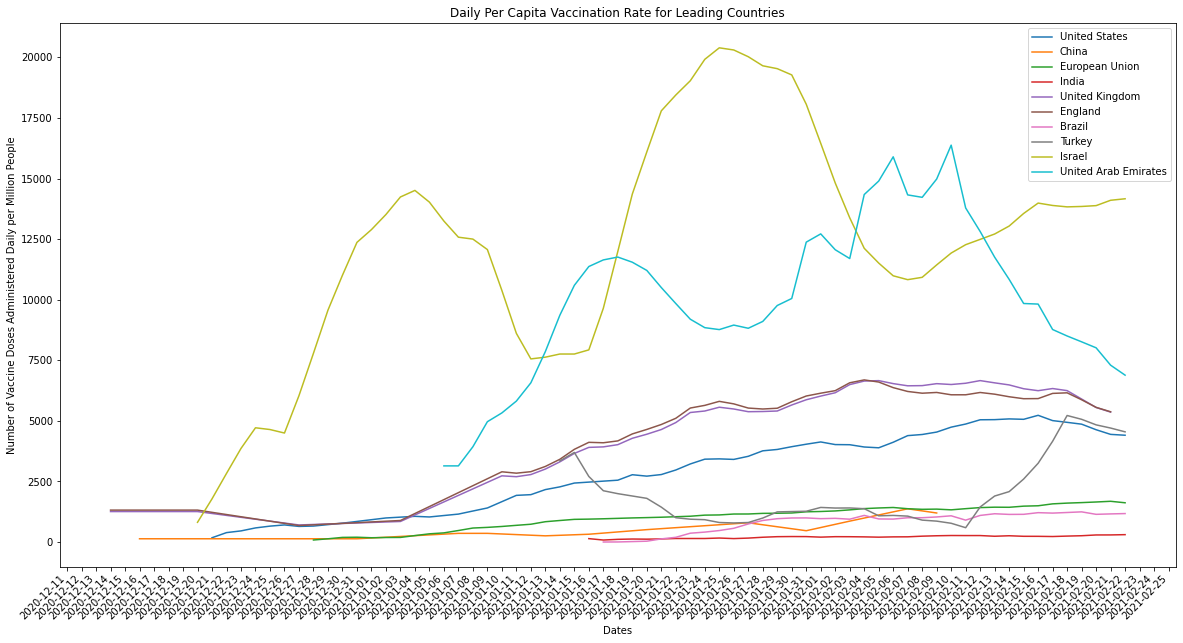

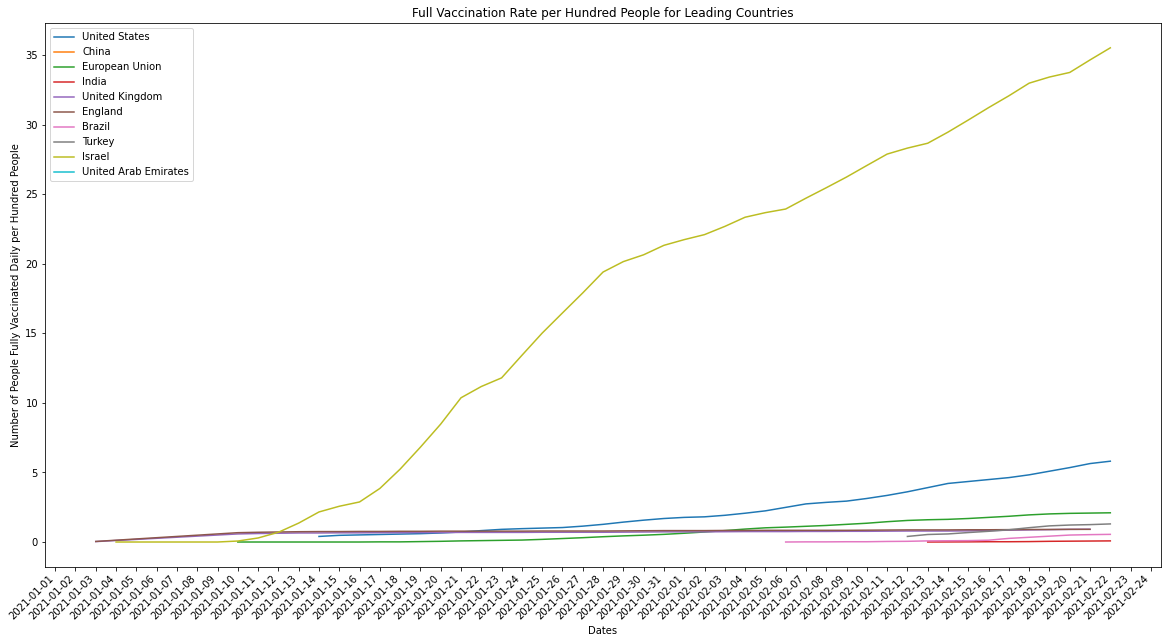

In [112]:
top_ten_items = sorted(dv_doses.items(), key=lambda item: item[1], reverse=True)[1:11]
top_ten_countries = []
for item in top_ten_items:
  top_ten_countries.append(item[0])

def plot_combined_linegraph(countries_arr, metric, ylabel, title, filename):
  # helper function to plot a combined linegraph of multiple countries by some metric in the vaccine_df
  #   input is an array of country names
  dv_df = vaccine_df[["location", "date", metric]].copy()
  dv_df.dropna(inplace=True, axis="index", how="any")

  fig, ax = plt.subplots(figsize=(20,10))

  for country in countries_arr:
    country_df = dv_df[dv_df["location"] == country]
    dates = country_df["date"].values
    x = [datetime.strptime(d, '%Y-%m-%d').date() for d in dates]
    y = country_df[metric].values
    plt.plot(x, y, label=country)

  # Let's configure pyplot properly

  formatter = mdates.DateFormatter("%Y-%m-%d")
  ax.xaxis.set_major_formatter(formatter)
  locator = mdates.DayLocator()
  ax.xaxis.set_major_locator(locator)
  plt.xticks(rotation=45, ha="right")

  plt.xlabel("Dates")
  plt.ylabel(ylabel)
  plt.title(title)

  # Now display and download the graph

  plt.legend()
  plt.show()

  fig.savefig(filename, bbox_inches='tight')

plot_combined_linegraph(top_ten_countries, metric="daily_vaccinations_per_million", 
                       ylabel="Number of Vaccine Doses Administered Daily per Million People",
                       title="Daily Per Capita Vaccination Rate for Leading Countries",
                       filename="daily_vaccinations_per_million.png")
plot_combined_linegraph(top_ten_countries, metric="people_fully_vaccinated_per_hundred", 
                       ylabel="Number of People Fully Vaccinated Daily per Hundred People",
                       title="Full Vaccination Rate per Hundred People for Leading Countries",
                       filename="daily_full_vaccinations_per_hundred.png")
    

The above should be adjusted to measure per capita, of course countries with big populations are outpacing smaller countries. I'll make it a parametrized option to either output a graph of raw `daily_vaccinations` or adjusted per capita `daily_vaccinations_per_million`.

Just to clarify, the countries being graphed above were the top ten when measured by the average number of doses administered in a day. When we compare the performance of countries in terms of how many vaccines they're able to administer we should always normalize for population. Larger countries by population, like the US or India, should ideally have more infrastructure and manpower available to deliver the vaccine at scale. What we end up seeing, however, is that the countries which were originally leaders in average number of doses delivered per day aren't actually delivering vaccines as efficiently as countries with smaller populations, and therefore lower raw doses delivered counts.

Israel is a small country by population when compared against the other countries in the top ten, but it is a leader in both raw counts of doses delivered per day and adjusted per capita rates. There's a couple explanations for this: the difference between how robust and efficient Israel's infrastructure is and it's size by population is huge and/or the infrastructure of large pop countries like India and the US is inefficient relative to their size. The latter is illustrated by the graph above, larger population countries don't compare well against smaller countries when measured using per capita rates. The former we can measure by graphing Israel against countries of a similar size by population (the k-nearest neighbors). 

9053300.0
['Israel' 'Austria' 'Tajikistan' 'Papua New Guinea' 'Belarus'
 'Switzerland' 'Honduras' 'Hungary' 'United Arab Emirates' 'Azerbaijan'
 'Togo']


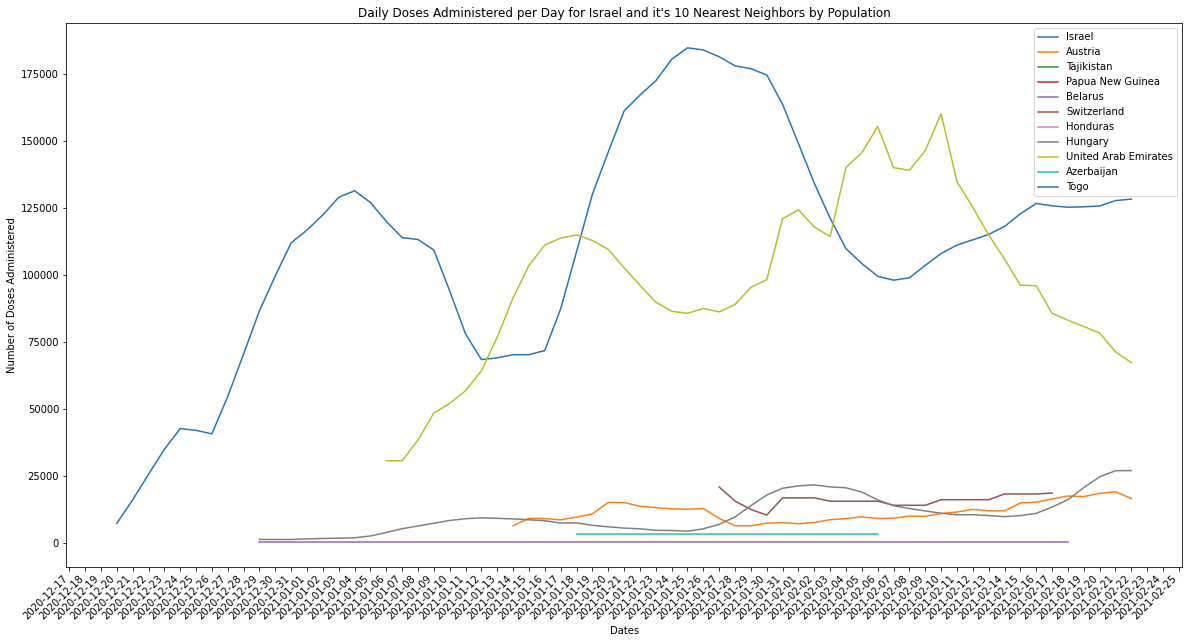

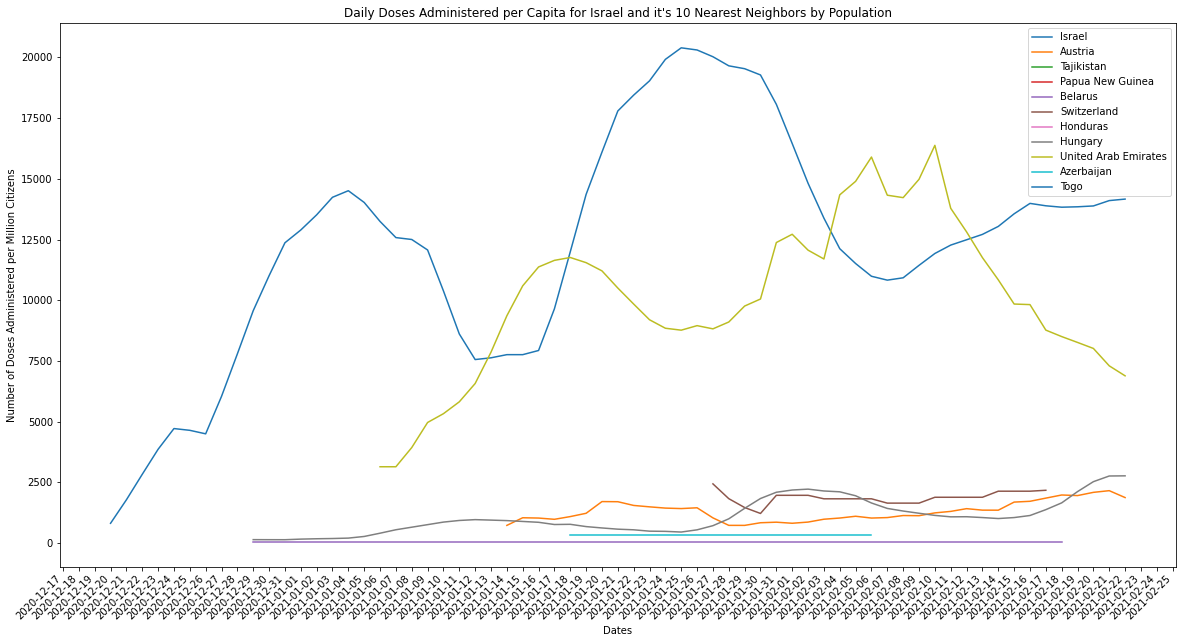

In [128]:
# take Israel and it's top ten nearest neighbors by population for the latest year it was reported for Israel (2019)
israel_pop = pop_df[pop_df["Country Name"] == "Israel"]["latest_available_population"].item()
israel_neighbors = pop_df.iloc[(pop_df["latest_available_population"]-israel_pop).abs().argsort()[:11]]["Country Name"].to_numpy()
# def plot_combined_linegraph(countries_arr, metric, ylabel, title, filename):
plot_combined_linegraph(israel_neighbors, metric="daily_vaccinations", 
                        ylabel="Number of Doses Administered",
                        title="Daily Doses Administered per Day for Israel and it's 10 Nearest Neighbors by Population",
                        filename="israel_neighbors_daily_doses.png")

plot_combined_linegraph(israel_neighbors, metric="daily_vaccinations_per_million", 
                        ylabel="Number of Doses Administered per Million Citizens",
                        title="Daily Doses Administered per Capita for Israel and it's 10 Nearest Neighbors by Population",
                        filename="israel_neighbors_daily_doses_per_capita.png")

I'll admit I did miss the fact that the UAE was also on both lists and is certainly a similar size by population as Israel. It does seem, however, that Israel and the UAE are far and away from their population neighbors in terms of vaccinations administered per day. It would seem that for their populations they certainly boast either more access to vaccine manufacturers/distributors, or the infrastructure to manufacture vaccines themselves.

To get a better idea of what factors impact the ability for a country to administer more vaccines per capita I need to compare vaccine distribution rates by other metrics pertaining to economic factors like GDP, government spend and national debt, and healthcare factors like healthcare spending, size in number of doctors and hospitals and ventilators and ICU capacity.

I'm going to load in a couple more datasets which I'll need to join by some common key. Country code seems like a good bet, and an inner join so we only take countries tracked in both datasets.

I'll make a couple graphs to make sure the dataset is of good quality, then I can run some principal component analysis to see which features have the greatest correlation with daily_vaccinations and people_fully_vaccinated. I can then use this to generate a smaller dataset of principal features, split into a testing and training set and start projecting daily_vaccinations and people_fully_vaccinated and calculate which country is most likely to reach herd immunity within their borders first.

It's obvious that I need to include much more historical data to train this model on, so I'll have to find data pertaining to previous government-led vaccine administration programs.

Ideally the place I'd like to get to with this is to incorporate some other datasets into this, calculate my own smoothed daily vaccination counts, then project future daily vaccination counts and try to predict which country will hit herd immunity first. I can then check my prediction against other peoples results and shop my projection model. I need to consider several regression models to use here, and do some dimensionality reduction.

I also want to set up my own runtime environment in GCP with a Jupyter notebook frontend.